Data needed in input: 
- split-channel confocal images (20x lens, binned 2x2 here) of binary systems in water-in-oil droplets (synthetic cells). These images can be obtained by simply opening the images in "Confocal_micrographs/Droplets - Confocal Micrographs/20x FOVs/Binary_sticky_mixtures/" in ImageJ/FIJI and saving each channel (BF, MG, DFHBI) as a separate TIFF file with channel tag (`_BF`, `_MG_`, `_DFHBI_`) in the filename. All images need to be placed  within `image_dir`.

Remember to define both the image and results directory, i.e. `image_dir` and `results_dir`. 

# Imports and functions

In [1]:
# Import dependencies
import cv2
import matplotlib as mpl
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from PIL import Image
from skimage import exposure
from skimage.util import img_as_ubyte
from tqdm import tqdm

In [2]:
# Helper function to convert image to 8 bit
def convert_8bit(image): 
    return img_as_ubyte(image)


# Helper function to enhance contrast by saturating a certain percent (perc) of pixels
def enhance_contrast(img, perc = 0.2):
    # Contrast stretching
    p_low, p_high = np.percentile(img, (perc, 100-perc))
    img_rescale = exposure.rescale_intensity(img, in_range=(p_low, p_high))
    return img_rescale


# Helper function to create composite image given two single-channel images
def get_composite_dualcolor(image_ch1, image_ch2, green = None):
    if image_ch1.shape[1] == 2:
        R = np.array(image_ch1)[:, :, 0] # cv2 reads images as color with identical channels - just fetch one
        if green is None: 
            G = np.zeros_like(R)
        elif green is not None: 
            G = np.array(green)[:, :, 0]
        B = np.array(image_ch2)[:, :, 0]
    else: 
        R = np.array(image_ch1)
        if green is None: 
            G = np.zeros_like(R)
        elif green is not None: 
            G = np.array(green)
        B = np.array(image_ch2)
    return cv2.merge([B, G, R])

In [3]:
# Function to perform Circle Hough Transform 
# (same as the one used for bulk binary systems, but with different default parameters)
def run_CHT_fluo(
    patch_fluo, 
    blur=5, 
    param1=150, 
    param2=0.6, 
): 
    """
    Perform Circle Hough Transform on a fluorescence image patch.

    This function applies a median blur to the input image to reduce noise, 
    then converts the image to color to allow for circle overlays. It uses 
    Circle Hough Transform (OpenCV implementation, with HOUGH_GRADIENT_ALT method)
    to detect circles, and draws the detected circles on the image.

    Parameters:
    patch_fluo (numpy.ndarray): The input grayscale fluorescence image patch.
    blur (int): The kernel size for the median blur operation.
    param1 (float): The higher threshold for the Canny edge detector.
    param2 (float): The measure of circularity required for detected circles.
    
    Returns:
    tuple: A tuple containing:
        - circles (numpy.ndarray): A list of detected circles, each specified by (x, y, radius).
        - cimg (numpy.ndarray): The color image with the detected circles overlaid.
        - If no circles are detected, returns None.
    """
    # Blur (denoising step)
    patch_blur = cv2.medianBlur(patch_fluo, blur)
    # Convert to colour to draw circle overlays
    cimg = cv2.cvtColor(patch_blur,cv2.COLOR_GRAY2BGR)
    # Run actual CHT via more accurate HOUGH_GRADIENT_ALT
    # doc: https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#ga47849c3be0d0406ad3ca45db65a25d2d
    circles = cv2.HoughCircles(
        image=patch_blur,
        method=cv2.HOUGH_GRADIENT_ALT,  # method
        dp=1,  # Inverse ratio of the accumulator resolution to the image resolution
        minDist=20,  # Minimum distance between the centers of the detected circles.
        param1=param1,  # higher threshold of the two passed to the Canny edge detector
        param2=param2,  # circle "perfectness" measure
        minRadius=10,  # minimum circle radius
        maxRadius=150,  # maximum circle radius
    )
    # Process results from circle segmentation
    if circles is None: 
        return None
    if type(circles.any()) != 'NoneType': 
        circles = np.uint16(np.around(circles))
        for i in circles[0,:]:
            # draw the outer circle
            cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
            # draw the center of the circle
            cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
        return tuple(circles, cimg)

In [4]:
# Helper function to remove droplets which have overlapping bounding boxes
# During manual ROI selection, the user might have selected twice the same droplet. This 
# ensures only unique droplets are investigated.
def remove_overlapping_BBoxes(results, min_dist=20): 
    for sample in results.keys(): 
        print(sample)
        for repeat in results[sample].keys(): 
            # First fetch all bounding boxes for all ROIs of specific repeat
            ROIs_sample = []
            for ROI in results[sample][repeat].keys(): 
                x1, y1, w, h = results[sample][repeat][ROI]['BoundingBox']
                centre = [int(x1+(w/2)), int(y1+(h/2))]
                size_x = w
                size_y = h
                ROIs_sample.append([centre, size_x, size_y])
            # Now compare the bounding boxes
            indices = []
            for i in range(len(ROIs_sample)): 
                for j in range(i+1, len(ROIs_sample)): 
                    if (
                        np.abs(ROIs_sample[i][0][0] - ROIs_sample[j][0][0]) < min_dist  # distance in X
                        and np.abs(ROIs_sample[i][0][1] - ROIs_sample[j][0][1]) < min_dist  # distance in Y
                    ): 
                        if ROIs_sample[i][1] > ROIs_sample[j][1] and ROIs_sample[i][2] > ROIs_sample[j][2]: 
                            indices.append(j)
                        else: 
                            indices.append(i)  # only keep the larger object
            # Reverse list of indices to remove
            indicesList = sorted(indices, reverse=True)
            # and then traverse index list to remove ROIs corresponding to `indices`
            for index in indicesList:
                if index in results[sample][repeat].keys(): 
                    print('Deleting ROI: ', index)
                    del results[sample][repeat][index]
    return results

In [5]:
# Helper functions to remove overlapping circles found using CHT
# In this case, given a unique ROI, the same condensate/organelle might be detected more than once.
# This ensures only the larger object is kept.
def remove_superimposing(circles, min_dist): 
    xs, ys, rs = [], [], []
    indices = []
    for i in range(len(circles[0])):
        for j in range(i+1, len(circles[0])): 
            if (
                np.abs(float(circles[0][i][0]) - float(circles[0][j][0])) < min_dist
                and np.abs(float(circles[0][i][1]) - float(circles[0][j][1])) < min_dist
            ): 
                # Discard index corresponding to smaller object
                if circles[0][i][2] >= circles[0][j][2]: 
                    indices.append(j)
                elif circles[0][i][2] <= circles[0][j][2]: 
                    indices.append(i)
    if len(set(indices)) > 0: 
        print('Excluded indices: ', set(indices))
    return [
        [circles[0][i][0], circles[0][i][1], circles[0][i][2]] 
        for i in range(len(circles[0]))  if i not in indices
    ]


def remove_overlapping_circles(results, sample_keys=['A', 'B'], min_dist=10): 
    new_results = results.copy()
    # Loop through samples (i.e. sample template ratios: 0.25, 0.5, 1, 2, 4)
    for sample in new_results.keys(): 
        print(sample)
        for repeat in new_results[sample].keys(): 
            for ROI in new_results[sample][repeat].keys(): 
                # Loop through sample keys (A, B)
                for sample_key in sample_keys: 
                    new_results[sample][repeat][ROI][sample_key] = remove_superimposing(
                        new_results[sample][repeat][ROI][sample_key], 
                        min_dist
                    )
    return new_results

In [6]:
# Pipeline
def pipeline_ROI_selection(image_bf, image_ch1, image_ch2): 
    '''
    Takes in brightfield, MG and DFHBI images (`image_bf`, `image_ch1` and `image_ch2`).
    Asks the user to select ROIs in the brightfield image, then performs Circle Hough Transform 
    on the corresponding contrast-enhanced patches in fluorescent channels.
    
    params: 
        image_bf: bright-field image
        image_ch1: MG channel image
        image_ch2: DFHBI channel image
    
    returns: 
        results: dictionary with ROIs as keys, nanostar type and bounding box
            coordinates as subkeys ('A', 'B', 'BoundingBox')
    '''

    # Initialise results dict
    results = {}
    # Select ROIs function from cv2 using composite of 
    # all channels to better identify droplets (brightfield appears in green)
    ROIs = cv2.selectROIs(
        "Select Rois",
        get_composite_dualcolor(
            image_ch1=image_ch1, 
            image_ch2=image_ch2, 
            green=enhance_contrast(image_bf)
        ), 
        fromCenter = False
    )
    cv2.startWindowThread()

    # Images are read as RGB colour, but they are all single channels - extract
    image_bf = image_bf[:, :, 0]
    image_ch1 = image_ch1[:, :, 0]
    image_ch2 = image_ch2[:, :, 0]
    
    # Loop over every bounding box save in array "ROIs"
    for ind, rect in enumerate(ROIs):
        x1, y1, x2, y2 =rect

        # Crop roi from fluorescent channels -> fluorescent patches
        ch1_crop=image_ch1[y1:y1+y2,x1:x1+x2]
        ch2_crop=image_ch2[y1:y1+y2,x1:x1+x2]
        
        # Convert to numpy arrays, then to 8 bit
        ch1_crop=convert_8bit(np.array(ch1_crop))
        ch2_crop=convert_8bit(np.array(ch2_crop))
        
        # Run CHT on fluorescent patches from both channels
        results_ch1, results_ch2 = (
            run_CHT_fluo(
                enhance_contrast(cropped_patch), 
                blur=5, 
                param1=150, 
                param2=0.6, 
                return_img=True,
            )
            for cropped_patch in (ch1_crop, ch2_crop)
        )
        # Check that circular objects were found in BOTH channels
        # In that case, the result is a tuple. Otherwise, the result is None.
        if isinstance(results_ch1, tuple) and isinstance(results_ch2, tuple): 
            circles_ch1, cimg1 = results_ch1
            circles_ch2, cimg2 = results_ch2
        else: 
            circles_ch1, circles_ch2 = None, None
            
        if (circles_ch1 is not None) and (circles_ch2 is not None): 
            plt.subplots(1, 4, figsize = (12, 3))
            plt.subplot(141)
            plt.imshow(ch1_crop)
            plt.title('Ch1 Patch')
            plt.subplot(142)
            plt.imshow(cimg1)
            plt.title('Ch1 HCT')
            plt.subplot(143)
            plt.imshow(ch2_crop)
            plt.title('Ch2 Patch')
            plt.subplot(144)
            plt.imshow(cimg2)
            plt.title('Ch2 HCT')
            plt.show()
        
            results[ind] = {'A' : circles_ch1, 'B' : circles_ch2, 'BoundingBox' : [x1, y1, x2, y2]}
        

    cv2.destroyAllWindows()
    for i in range (len(ROIs)):
        cv2.waitKey(1)
    
    return results

In [7]:
# Helper function to inspect all results and discard incorrect ROIs or found circular objects
def approve_roi_results(results, files): 
    """
    Allows manual inspection of analysis results (`results`) obtained by running 
    `pipeline_ROI_selection` on `files`. 
    Returns user-selected/approved `results`. 
    """
    
    ROIs_to_delete = {}
    for sample in results.keys(): 
        ROIs_to_delete[sample] = {}
        print(sample)
        for repeat in results[sample].keys(): 
            ROIs_to_delete[sample][repeat] = []
            image_bf = cv2.imread(files[sample]['BF'][repeat])
            image_ch1 = cv2.imread(files[sample]['MG'][repeat])
            image_ch2 = cv2.imread(files[sample]['DFHBI'][repeat])
            for ROI in results[sample][repeat].keys(): 
                rect = results[sample][repeat][ROI]['BoundingBox']
                x1, y1, x2, y2 =rect
            
                #crop roi from BF and fluorescent channels
                bf_crop = image_bf[:, :, 0][y1:y1+y2,x1:x1+x2]
                ch1_crop= image_ch1[:, :, 0][y1:y1+y2,x1:x1+x2]
                ch2_crop= image_ch2[:, :, 0][y1:y1+y2,x1:x1+x2]

                #Convert to numpy arrays, then to 8 bit
                bf_crop=convert_8bit(np.array(bf_crop))
                ch1_crop=convert_8bit(np.array(ch1_crop))
                ch2_crop=convert_8bit(np.array(ch2_crop))
                
                # Convert fluorescent images to colour to overlay circles
                cimg1 = cv2.cvtColor(ch1_crop,cv2.COLOR_GRAY2BGR)
                cimg2 = cv2.cvtColor(ch2_crop,cv2.COLOR_GRAY2BGR)
                
                circles_a = results[sample][repeat][ROI]['A']
                circles_b = results[sample][repeat][ROI]['B']
                
                # A condensates
                circles_a = np.uint16(np.around(circles_a))
                for i in circles_a:
                    # draw the outer circle
                    cv2.circle(cimg1,(i[0],i[1]),i[2],(0,255,0),2)
                    # draw the center of the circle
                    cv2.circle(cimg1,(i[0],i[1]),2,(0,0,255),3)
                
                
                circles_b = np.uint16(np.around(circles_b))
                for i in circles_b:
                    # draw the outer circle
                    cv2.circle(cimg2,(i[0],i[1]),i[2],(0,255,0),2)
                    # draw the center of the circle
                    cv2.circle(cimg2,(i[0],i[1]),2,(0,0,255),3)
        
                # Plot result for examination
                plt.subplots(1, 5, figsize = (12, 3))
                plt.subplot(151)
                plt.imshow(ch1_crop)
                plt.title('Ch1 Patch')
                plt.subplot(152)
                plt.imshow(cimg1)
                plt.title('Ch1 HCT')
                plt.subplot(153)
                plt.imshow(ch2_crop)
                plt.title('Ch2 Patch')
                plt.subplot(154)
                plt.imshow(cimg2)
                plt.title('Ch2 HCT')
                plt.subplot(155)
                plt.imshow(
                    get_composite_dualcolor(
                        ch1_crop, 
                        ch2_crop, 
                        enhance_contrast(bf_crop)
                    )
                )
                plt.title('Composite')
                plt.show()
                
                # Ask user whether result makes sense and should be kept
                keep = input('Keep this selection? (Y/N) ')
                if keep.upper() == 'N': 
                    print('ROI will be deleted!')
                    ROIs_to_delete[sample][repeat].append(ROI)
                    
    for sample in results.keys(): 
        for repeat in results[sample].keys(): 
            for ROI in ROIs_to_delete[sample][repeat]: 
                del results[sample][repeat][ROI]          
    return results

# Define directories and image files

In [8]:
# CHANGE TO ABSOLUTE PATH TO IMAGE DIRECTORY
image_dir = "/ABSOLUTE/PATH/TO/IMAGE/DIRECTORY/"
# CHANGE TO ABSOLUTE PATH TO RESULTS DIRECTORY
results_dir = "/ABSOLUTE/PATH/TO/RESULTS/DIRECTORY/"

In [ ]:
os.chdir(image_dir)

# Define filepaths dictionary
sample_keys = ['A1:B4', 'A1:B2', 'A1:B1', 'A2:B1', 'A4:B1']  # [A-T]/[B-T] ratio
inner_keys = ['BF', 'MG', 'DFHBI']  # channel keys
files = {
    key : {inner_key : [] for inner_key in inner_keys} 
    for key in sample_keys
}

file_list = [image_dir + str(i) for i in os.listdir()]

for file in file_list: 
    # Determining sample - outer key
    if '_ratio0.25' in file: 
        outer_key = 'A1:B4'
    elif '_ratio0.50' in file: 
        outer_key = 'A1:B2'
    elif '_ratio1' in file: 
        outer_key = 'A1:B1'
    elif '_ratio2' in file: 
        outer_key = 'A2:B1'
    elif '_ratio4' in file: 
        outer_key = 'A4:B1'
    else: 
        print('Uncategorised sample in this image filepath: ', file)
        
    # Determining channel - inner key
    if '_BF_' in file: 
        inner_key = 'BF'
    elif '_MG_' in file: 
        inner_key = 'MG'
    elif '_DFHBI_' in file: 
        inner_key = 'DFHBI'
    else: 
        print('Uncategorised channel in this image filepath: ', file)
        
    # Finally sorting each file to the right section of the files dictionary
    files[outer_key][inner_key].append(file)

# Run ROI selection pipeline

In [ ]:
# Run pipeline
# Initialise results dictionary
results = {}
# Loop through samples
for i, sample in enumerate(files.keys()):
    results[sample] = {}
    print('Now analysing sample: ', sample)
    # Compute number of repeats from the number of bright-field images for the particular sample
    num_repeats = len(files[sample]['BF'])
    # Loop through repeats (if any)
    for repeat in range(num_repeats):
        print('Repeat: ', repeat, '/', num_repeats) 
        # Open relevant images
        image_bf = cv2.imread(files[sample]['BF'][repeat])
        image_mg = cv2.imread(files[sample]['MG'][repeat])
        image_dfhbi = cv2.imread(files[sample]['DFHBI'][repeat])
        # Save results in the corresponding entry of the results dictionary
        results[sample][repeat] = pipeline_ROI_selection(image_bf, image_mg, image_dfhbi)    

In [ ]:
# Pipeline results can be saved
np.save(results_dir + 'intermediate_droplet_binary_pipeline_results.npy', results, allow_pickle = True)

# Reload intermediate results and perform quality controls

In [ ]:
# This way, results can be loaded without having to perform the pipeline every time
results = np.load(results_dir + 'intermediate_droplet_binary_pipeline_results.npy', allow_pickle = True).item()

In [ ]:
mapping = {
    '14': 'A1:B4', 
    '12': 'A1:B2',
    '11': 'A1:B1',
    '21': 'A2:B1', 
    '41': 'A4:B1'
}

new_results = {}
for template_ratio in results.keys(): 
    new_results[mapping[template_ratio]] = {}
    for repeat in results[template_ratio].keys(): 
        new_results[mapping[template_ratio]][repeat] = {}
        for roi in results[template_ratio][repeat].keys(): 
            new_results[mapping[template_ratio]][repeat][roi] = {
                'A': results[template_ratio][repeat][roi]['MG'],
                'B': results[template_ratio][repeat][roi]['Br'],
                'BoundingBox': results[template_ratio][repeat][roi]['BoundingBox'],
            }

In [ ]:
# Remove overlapping selections (centres of bounding boxes within 75px of each other in both x and y)
results_removed = remove_overlapping_BBoxes(results, min_dist=75)

In [ ]:
# For each ROI, remove superimposing circular objects (centres within 10px in both X and Y coordinates)
results_removed = remove_overlapping_circles(results_removed, min_dist=10)

In [ ]:
results_approved = approve_roi_results(results_removed, files)

In [ ]:
# Save final results
np.save(results_dir+'final_droplet_binary_pipeline_results.npy', results_approved, allow_pickle = True)

# Reload final manually checked results

In [9]:
# Results can be reloaded for plotting without re-running the whole pipeline
results_approved = np.load(results_dir+'final_droplet_binary_pipeline_results.npy', allow_pickle = True).item()

# Plots

## Radial Ratio

In [10]:
# Function to process the results dictionary into two dictionaries, 
# one with number of droplets and the other with condensate sizes (radii) 
# per sample template ratio (dict key).
def get_num_sizes(res_dict):    
    """
    params: 
        res_dict: results dictionary from pipeline + quality controls
        
    returns: 
        num: dictionary with template ratios as keys, sample/nanostar (A/B) as subkeys, 
            and list of numbers of corresponding organelles found in each droplet as values.
        sizes: dictionary with template ratios as keys, sample/nanostar (A/B) as subkeys, 
            and list of radii of corresponding organelle found in each droplet as values
            (only for droplets containing exactly 1A and 1B organelles).
    """
    # Initialise output dictionaries
    num, sizes = {}, {}
    for template_ratio in res_dict.keys(): 
        num[template_ratio], sizes[template_ratio] = {'A': [], 'B': []}, {'A': [], 'B': []}
        for repeat in res_dict[template_ratio].keys(): 
            for ind, ROI in enumerate(res_dict[template_ratio][repeat].keys()): 
                num[template_ratio]['A'].append(len(res_dict[template_ratio][repeat][ROI]['A']))
                num[template_ratio]['B'].append(len(res_dict[template_ratio][repeat][ROI]['B']))
                # Only keep droplets with 1 A condensate and 1 B condensate
                if (
                    (len(res_dict[template_ratio][repeat][ROI]['A']) == 1) 
                    & (len(res_dict[template_ratio][repeat][ROI]['B']) == 1)
                ): 
                    sizes[template_ratio]['A'].append(
                        sum(
                            [
                                circle[2] 
                                for circle in res_dict[template_ratio][repeat][ROI]['A']
                            ]
                        )
                    )
                    sizes[template_ratio]['B'].append(
                        sum(
                            [
                                circle[2] 
                                for circle in res_dict[template_ratio][repeat][ROI]['B']
                            ]
                        )
                    )
    return num, sizes

In [11]:
# Process results
num, sizes = get_num_sizes(results_approved)

In [12]:
# Intermediate processing to produce pandas DataFrame for plot
size_ratios = []
size_a = []
size_b = []
sample_ratio_list = []
num_samples = []

for sample in sizes.keys(): 
    temp_size_ratios = np.array(sizes[sample]['A'])/np.array(sizes[sample]['B'])
    size_ratios += list(temp_size_ratios)
    size_a += sizes[sample]['A']
    size_b += sizes[sample]['B']
    sample_ratio_list += len(list(temp_size_ratios))*[sample]
    num_samples.append(len(list(temp_size_ratios)))
    
assert len(size_ratios) == len(sample_ratio_list)

# Build pandas DataFrame
size_ratio_droplet = pd.DataFrame({'Sample': np.array(sample_ratio_list), 
                           'Size_A' : np.array(size_a),
                           'Size_B' : np.array(size_b),
                           'SizeRatio': np.array(size_ratios)})
size_ratio_droplet.replace([np.inf, -np.inf], np.nan, inplace=True)
size_ratio_droplet.dropna(inplace = True)

In [13]:
# Define colour palettes for plots
extremes = ['firebrick', 'cyan']
extremes_rgba = np.array([np.array(mpl.colors.to_rgba(color, alpha=None)) for color in extremes])
in_between_colors = [(i/5)*extremes_rgba[0] + (5-i)/5*extremes_rgba[1] for i in range(1, 6)]

extremes_v2 = ['orangered', 'cyan']
extremes_v2_rgba = np.array([np.array(mpl.colors.to_rgba(color, alpha=None)) for color in extremes_v2])
in_between_colors_v2 = [(i/5)*extremes_v2_rgba[0] + (5-i)/5*extremes_v2_rgba[1] for i in range(1, 6)]

in_between_colors[-2:] = in_between_colors_v2[-2:]

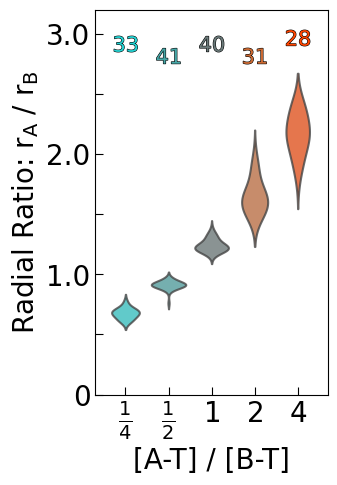

In [14]:
# Figure 3f
mpl.rcParams['mathtext.default'] = 'regular'

plt.figure(figsize = (3, 5))
ax = sns.violinplot(
    x='Sample', 
    y='SizeRatio', 
    data=size_ratio_droplet, 
    scale='count', 
    palette=in_between_colors, 
    inner = None, 
    bw = 0.7,
)
ax.set_xlabel(r'[A-T] / [B-T]', fontsize = 20)
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xticklabels([r'$\frac{1}{4}$', r'$\frac{1}{2}$', r'$1$', r'$2$', r'$4$'], fontsize = 20)
ax.set_yticks([0, 0.5, 1.00, 1.5, 2.0, 2.5, 3.00])
ax.set_yticklabels([0, '', 1.00, '', 2.00, '', 3.00], fontsize = 20)
plt.xlim([-0.7, 4.7])
plt.ylim([0, 3.2])
ax.set_ylabel(r'Radial Ratio: r$_{A}$ / r$_{B}$', fontsize = 20)
ax.tick_params(direction = 'in', length = 6)
plt.setp(ax.collections, alpha=.8);

# Include number of analysed droplets (with 1 A and 1B condensate)
positions = np.arange(-0.3, 4.7, 5./len(num_samples))
for ind, height in zip(range(len(positions)), [2.85, 2.75, 2.85, 2.75, 2.90]):
    plt.text(
        positions[ind], 
        height, 
        num_samples[ind], 
        fontsize=15, 
        color=in_between_colors[ind], 
        path_effects=[pe.withStroke(linewidth=0.8, foreground="black")]
    )
plt.show()

## Fraction of Synthetic Cells containing N organelles/condensates

In [15]:
# Number of examined droplets reported in plot above only reflects droplets with 1 A condensate 
# and 1 B condensate. Let's check how many droplets contain 1, 2 and 3 A or B condensates 
# and compute the total number of the examined droplets (regardless of how many A/B condensates/organelles
# they contain, as long as they contain at least one of each.)
for template_ratio in num.keys(): 
    for nanostar in ['A', 'B']: 
        num[template_ratio][nanostar+'_count'] = []
        for number in [1, 2, 3]: 
            num[template_ratio][nanostar+'_count'].append(
                list(num[template_ratio][nanostar]).count(number)
            )
    assert sum(num[template_ratio]['A_count']) == sum(num[template_ratio]['B_count'])
    num[template_ratio]['count_total'] = sum(num[template_ratio]['A_count'])

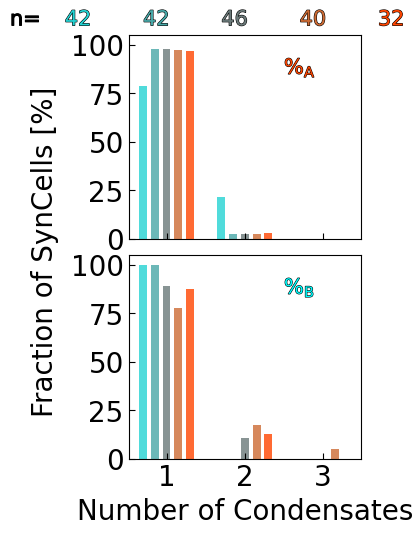

In [16]:
# Figure 3g
plt.subplots(2, 1, figsize = (3, 5.5), sharey = True, sharex = True)
plt.subplots_adjust(hspace = 0.08)

plt.subplot(211)
for ind, sample in enumerate(num.keys()): 
    plt.bar(
        [0.7+ind*.15, 1.7+ind*.15, 2.7+ind*.15], 
        100*np.array(num[sample]['A_count'])/num[sample]['count_total'], 
        color=in_between_colors[ind], 
        alpha=0.8, 
        width=0.1
    )
plt.xticks([1, 2, 3], [], fontsize = 20)
plt.yticks([0, 25, 50, 75, 100], [0, 25, 50, 75, 100], fontsize = 20)
ax = plt.gca()
ax.tick_params(direction = 'in', length = 4)

# Label - % A organelles
plt.text(
    2.5, 
    85, 
    r'$\%_{A}$', 
    fontsize=15, 
    color='orangered', 
    path_effects=[pe.withStroke(linewidth=0.8, foreground="black")]
)

# Add number of examined droplets up top
plt.text(
    -1, 
    110, 
    'n=', 
    fontsize=15, 
    color='black', 
    path_effects=[pe.withStroke(linewidth=0.8, foreground="black")]
)
for position, sample, color in zip(
    positions, 
    ['A1:B4', 'A1:B2', 'A1:B1', 'A2:B1', 'A4:B1'], 
    in_between_colors
):
    plt.text(
        position, 
        110, 
        num[sample]['count_total'], 
        fontsize=15, 
        color=color,
        path_effects=[pe.withStroke(linewidth=0.8, foreground="black")]
    )

    
plt.subplot(212)
for ind, sample in enumerate(num.keys()): 
    plt.bar(
        [0.7+ind*.15, 1.7+ind*.15, 2.7+ind*.15], 
        100*np.array(num[sample]['B_count'])/num[sample]['count_total'], 
        color=in_between_colors[ind], 
        alpha = 0.8,  
        width = 0.1
    )
plt.ylabel('Fraction of SynCells [%]', fontsize = 20)
plt.xticks([1, 2, 3], [1, 2, 3], fontsize = 20)
plt.xlabel('Number of Condensates', fontsize = 20)
plt.yticks([0, 25, 50, 75, 100], [0, 25, 50, 75, 100], fontsize = 20)
ax = plt.gca()
ax.yaxis.set_label_coords(-0.3,1.02)
ax.tick_params(direction = 'in', length = 4)

# Label - % B organelles
plt.text(
    2.5, 
    85, 
    r'$\%_{B}$', 
    fontsize=15, 
    color='cyan', 
    path_effects=[pe.withStroke(linewidth=0.8, foreground="black")]
)
plt.show()